In [1]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field
from typing import List, Literal, Optional, Annotated
from langgraph.graph.message import add_messages, AnyMessage
from dotenv import load_dotenv
import uuid
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

load_dotenv()

class InterviewState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list)
    
    student_name: str = ""
    college: str = ""
    course: str = ""
    
    topic: Optional[str] = None
    difficulty: Optional[Literal["beginner", "medium", "hard"]] = None
    
    question_pool: List[str] = Field(default_factory=list)
    asked_questions: List[str] = Field(default_factory=list)
    current_question: Optional[str] = None
    
    question_count: int = 0
    max_questions: int = 3
    
    last_user_input: Optional[str] = None
    intent: Optional[str] = None
    
    short_feedback: Optional[str] = None
    correction: Optional[str] = None
    correct: Optional[bool] = None

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)


In [2]:
INTERVIEW_RULES = """\
YOUR RULES — follow strictly:

1. Sound like a calm, friendly senior engineer.
2. Speak in short sentences. Max 2 sentences per reply.
3. Never long paragraphs. Never bullet points.
4. Ask only ONE clear question at a time.
5. Keep feedback 5–10 words maximum.
6. If answer is wrong, give short correction in one clean sentence.
7. Do NOT over-explain.
8. Do NOT repeat the same question again unless user explicitly asks.
9. If user asks to repeat, restate naturally — not robotic.
10. Use real-world commonly asked interview questions only.
11. you are talking via phone call.
"""

def build_system_prompt(student_name: str, college: str, course: str) -> str:
    return (
        f"You are arjun, an expert interviewer at 10000coders calling {student_name}.\n"
        f"Student: {student_name} | {college} | {course}\n\n"
        f"{INTERVIEW_RULES}"
    )


In [3]:
def emit_ai_message(content: str):
    print(f"\nAgent: {content}")

def load_candidate_context(state: InterviewState) -> dict:
    return {"messages": [SystemMessage(content=build_system_prompt(
        state.student_name, state.college, state.course
    ))]}

def intro_hook(state: InterviewState) -> dict:
    response = f"Hello! This is the interview agent. Am I speaking to {state.student_name}?"
    emit_ai_message(response)
    return {"messages": [response]}

def quit_call(state):
    msg = "Sorry about that. I’ll end the call here. Have a good day."
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}

def end_call(state):
    msg = "Thank you! Have a great day, Goodbye!"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}

def goodbye_node(state: InterviewState) -> dict:
    msg = "Thanks for your time. You'll receive detailed feedback soon. All the best."
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}


In [4]:
# Identity Flow
class IdentityIntent(BaseModel):
    intent: Literal["valid", "not_valid", "repeat", "silence"]

def identity_listen(state: InterviewState) -> dict:
    user_text = input("Candidate (type here): ").strip()
    print(f"\nCandidate: {user_text}")
    return {"last_user_input": user_text, "messages": [HumanMessage(content=user_text)]}

def identity_router(state: InterviewState) -> dict:
    user_text = state.last_user_input or ""
    structured_llm = llm.with_structured_output(IdentityIntent)
    result = structured_llm.invoke(
        f"""
        The assistant asked: "Am I speaking to {state.student_name}?"
        Classify the user's reply.
        Rules:
        - If clearly yes → valid
        - If clearly no → not_valid
        - If asking to repeat or unclear → repeat
        - If empty or meaningless → silence
        User reply: {user_text}
        """
    )
    return {"intent": result.intent}

def identity_repeat(state: InterviewState) -> dict:
    if state.intent == "silence":
        msg = "Hello? Can you hear me?"
    else:
        msg = f"Sure. I just wanted to confirm — am I speaking to {state.student_name}?"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}


In [5]:
# Topic Flow
class TopicIntent(BaseModel):
    intent: Literal["topic_valid", "repeat", "quit", "silence"]
    extracted_topic: Optional[str] = None

def topic_ask(state: InterviewState) -> dict:
    msg = "Which topic would you like to be interviewed on today?"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}

def topic_listen(state: InterviewState) -> dict:
    user_text = input("Candidate (type here): ").strip()
    print(f"\nCandidate: {user_text}")
    return {"last_user_input": user_text, "messages": [HumanMessage(content=user_text)]}

topic_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(TopicIntent)

def topic_router(state: InterviewState) -> dict:
    user_text = (state.last_user_input or "").strip()
    if user_text == "":
        return {"intent": "silence"}
    try:
        result = topic_llm.invoke([
            SystemMessage(content=("You are a strict intent classifier.\nAllowed intents:topic_valid, repeat, quit, silence.\nIf user clearly mentions a technical topic, extract it.\nDo not explain.")),
            HumanMessage(content=f"The assistant asked:\n\"Which topic would you like to be interviewed on today?\"\n\nUser reply:\n\"{user_text}\"")
        ])
        return {"intent": result.intent, "topic": result.extracted_topic or state.topic}
    except Exception:
        return {"intent": "repeat"}

def topic_repeat(state: InterviewState) -> dict:
    if state.intent == "silence":
        msg = "Hello? Can you hear me?"
    else:
        msg = "No problem. Which topic would you like to go with?"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}


In [6]:
# Difficulty Flow
class DifficultyIntent(BaseModel):
    intent: Literal["difficulty_answer", "repeat", "quit", "unknown"]
    extracted_difficulty: Optional[Literal["beginner", "medium", "hard"]] = None

def difficulty_ask(state: InterviewState) -> dict:
    msg = "What difficulty level would you prefer — beginner, medium, or hard?"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}

def difficulty_listen(state: InterviewState) -> dict:
    user_text = input("Candidate (type here): ").strip()
    print(f"\nCandidate: {user_text}")
    return {"last_user_input": user_text, "messages": [HumanMessage(content=user_text)]}

difficulty_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(DifficultyIntent)

def difficulty_router(state: InterviewState) -> dict:
    user_text = (state.last_user_input or "").strip()
    try:
        result = difficulty_llm.invoke([
            SystemMessage(content=("You are a strict intent classifier.\nAllowed intents: difficulty_answer, repeat, quit, unknown, silence.\nIf user clearly selects beginner, medium, or hard, extract it.\nDo not explain.")),
            HumanMessage(content=f"The assistant asked:\n\"What difficulty level would you prefer — beginner, medium, or hard?\"\n\nUser reply:\n\"{user_text}\"")
        ])
        if result.intent == "unknown":
            return {"intent": "repeat"}
        return {"intent": result.intent, "difficulty": result.extracted_difficulty or state.difficulty}
    except Exception:
        return {"intent": "repeat"}

def difficulty_repeat(state: InterviewState) -> dict:
    if state.intent == "silence":
        msg = "Hello? Can you hear me?"
    else:
        msg = "Sure. Would you like beginner, medium, or hard?"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}


In [7]:
# Question Flow
class QuestionBatch(BaseModel):
    questions: List[str]

question_gen_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3).with_structured_output(QuestionBatch)

def prepare_question_pool(state: InterviewState) -> dict:
    result = question_gen_llm.invoke(f"""
Generate exactly 3 commonly asked technical interview questions in India.
Topic: {state.topic}
Difficulty: {state.difficulty}
Rules:
- Keep questions short.
- Screening style.
- No essay questions.
- Avoid similar phrasing.
""")
    return {"question_pool": result.questions, "asked_questions": [], "question_count": 0}

def ask_question(state: InterviewState) -> dict:
    remaining_questions = [q for q in state.question_pool if q not in state.asked_questions]
    if not remaining_questions:
        msg = "Looks like we're out of questions."
        emit_ai_message(msg)
        return {"messages": [AIMessage(content=msg)]}
    question = remaining_questions[0]
    emit_ai_message(question)
    return {"current_question": question, "asked_questions": state.asked_questions + [question], "messages": [AIMessage(content=question)]}

def question_listen(state: InterviewState) -> dict:
    user_text = input("Candidate (type here): ").strip()
    print(f"\nCandidate: {user_text}")
    return {"last_user_input": user_text, "messages": [HumanMessage(content=user_text)]}

class QuestionIntent(BaseModel):
    intent: Literal["answer", "repeat", "quit", "unknown"]

question_router_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(QuestionIntent)

def question_intent_router(state: InterviewState) -> dict:
    user_text = (state.last_user_input or "").strip()
    if user_text == "":
        return {"intent": "silence"}
    try:
        result = question_router_llm.invoke([
            SystemMessage(content=("You are a strict intent classifier.\nAllowed intents: answer, repeat, quit.\nIf user asks to hear the question again → repeat.\nIf user wants to stop → quit.\nOtherwise treat as answer.\nDo not explain.")),
            HumanMessage(content=f"Question: {state.current_question}\n\nUser reply:\n\"{user_text}\"")
        ])
        if result.intent == "unknown":
            return {"intent": "answer"}
        return {"intent": result.intent}
    except Exception:
        return {"intent": "answer"}

def question_repeat(state: InterviewState) -> dict:
    if state.intent == "silence":
        msg = "Hello? Can you hear me?"
    else:
        msg = f"No problem. {state.current_question}"
    emit_ai_message(msg)
    return {"messages": [AIMessage(content=msg)]}

class EvaluationSchema(BaseModel):
    correct: bool
    short_feedback: str
    correction: str | None

evaluation_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(EvaluationSchema)

def evaluate_answer(state: InterviewState) -> dict:
    result = evaluation_llm.invoke([
        SystemMessage(content=("You are a technical interviewer.\nKeep feedback 5–10 words.\nIf wrong, correction must be short and conversational.\nDo not explain in paragraphs.")),
        HumanMessage(content=f"Question: {state.current_question}\nAnswer: {state.last_user_input}")
    ])
    
    if result.correct:
        message = result.short_feedback
    else:
        message = f"{result.short_feedback} A better way is: {result.correction}"
    
    emit_ai_message(message)
    return {
        "correct": result.correct, 
        "short_feedback": result.short_feedback, 
        "correction": result.correction,
        "messages": [AIMessage(content=message)],
        "question_count": state.question_count + 1
    }


✅ Interview LangGraph compiled successfully.


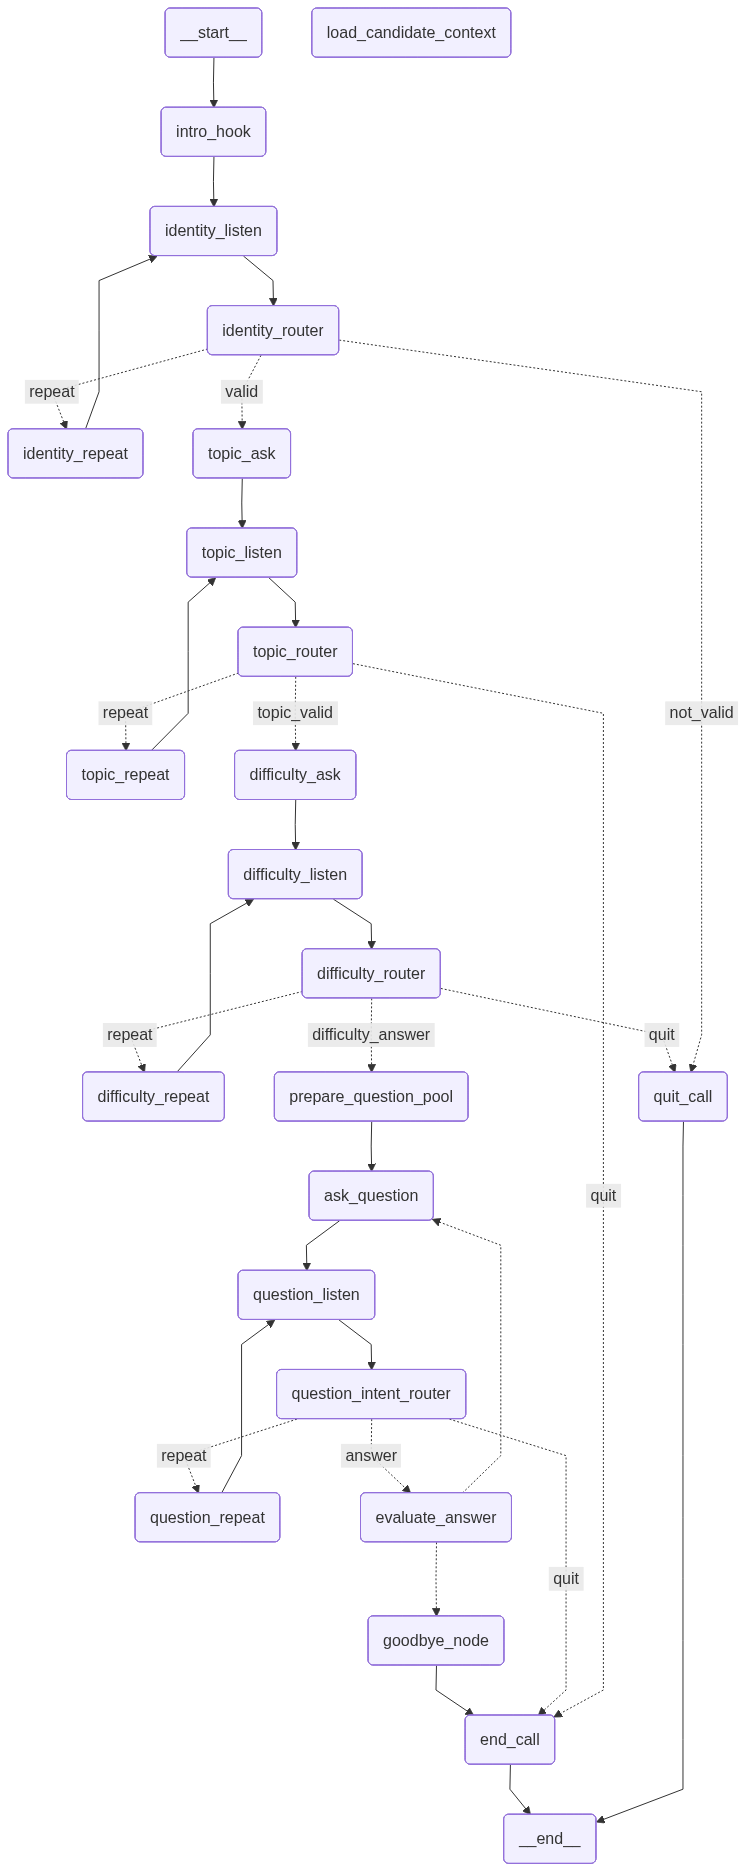

In [8]:
# Build Graph
builder = StateGraph(InterviewState)

builder.add_node("load_candidate_context", load_candidate_context)
builder.add_node("intro_hook", intro_hook)
builder.add_node("identity_listen", identity_listen)
builder.add_node("identity_router", identity_router)
builder.add_node("identity_repeat", identity_repeat)
builder.add_node("topic_ask", topic_ask)
builder.add_node("topic_listen", topic_listen)
builder.add_node("topic_router", topic_router)
builder.add_node("topic_repeat", topic_repeat)
builder.add_node("difficulty_ask", difficulty_ask)
builder.add_node("difficulty_listen", difficulty_listen)
builder.add_node("difficulty_router", difficulty_router)
builder.add_node("difficulty_repeat", difficulty_repeat)
builder.add_node("prepare_question_pool", prepare_question_pool)
builder.add_node("ask_question", ask_question)
builder.add_node("question_intent_router", question_intent_router)
builder.add_node("question_repeat", question_repeat)
builder.add_node("question_listen", question_listen)
builder.add_node("evaluate_answer", evaluate_answer)
builder.add_node("goodbye_node", goodbye_node)
builder.add_node("quit_call", quit_call)
builder.add_node("end_call", end_call)

builder.set_entry_point("intro_hook")

builder.add_edge("intro_hook", "identity_listen")
builder.add_edge("identity_listen", "identity_router")
builder.add_conditional_edges("identity_router", lambda state: state.intent, {
    "valid": "topic_ask",
    "not_valid": "quit_call",
    "repeat": "identity_repeat",
    "silence": "identity_repeat",
})
builder.add_edge("identity_repeat", "identity_listen")

builder.add_edge("topic_ask", "topic_listen")
builder.add_edge("topic_listen", "topic_router")
builder.add_conditional_edges("topic_router", lambda state: state.intent, {
    "topic_valid": "difficulty_ask",
    "repeat": "topic_repeat",
    "quit": "end_call",
    "silence": "topic_repeat",
})
builder.add_edge("topic_repeat", "topic_listen")

builder.add_edge("difficulty_ask", "difficulty_listen")
builder.add_edge("difficulty_listen", "difficulty_router")
builder.add_conditional_edges("difficulty_router", lambda state: state.intent, {
    "difficulty_answer": "prepare_question_pool",
    "repeat": "difficulty_repeat",
    "quit": "quit_call",
    "silence": "difficulty_repeat",
})
builder.add_edge("difficulty_repeat", "difficulty_listen")

builder.add_edge("prepare_question_pool", "ask_question")
builder.add_edge("ask_question", "question_listen")
builder.add_edge("question_listen", "question_intent_router")
builder.add_conditional_edges("question_intent_router", lambda state: state.intent, {
    "answer": "evaluate_answer",
    "repeat": "question_repeat",
    "quit": "end_call",
    "silence": "question_repeat",
})
builder.add_edge("question_repeat", "question_listen")
builder.add_conditional_edges("evaluate_answer", lambda state: "goodbye_node" if state.question_count >= state.max_questions else "ask_question", {
    "goodbye_node": "goodbye_node",
    "ask_question": "ask_question"
})

builder.add_edge("goodbye_node", "end_call")
builder.add_edge("end_call", END)
builder.add_edge("quit_call", END)

graph = builder.compile()
print("✅ Interview LangGraph compiled successfully.")

graph

In [9]:
# Run the graph interactively
initial_state = {
    "student_name": "Arjun",
    "college": "reva univeraity",
    "course": "btech cse"
}
print("--- Starting Call ---")
# Setting recursion_limit high so it does not stop prematurely
for event in graph.stream(initial_state, {"recursion_limit": 100}):
    pass
print("\n--- Call Ended ---")


--- Starting Call ---

Agent: Hello! This is the interview agent. Am I speaking to Arjun?

Agent: Which topic would you like to be interviewed on today?


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=IdentityIntent(intent='valid'), input_type=IdentityIntent])
  return self.__pydantic_serializer__.to_python(



Agent: What difficulty level would you prefer — beginner, medium, or hard?


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=TopicIntent(intent='topic..., extracted_topic='sql'), input_type=TopicIntent])
  return self.__pydantic_serializer__.to_python(
c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=DifficultyIntent(intent='...d_difficulty='beginner'), input_type=DifficultyIntent])
  return self.__pydantic_serializer__.to_python(



Agent: What is the difference between INNER JOIN and LEFT JOIN?


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=QuestionBatch(questions=[... why is it important?']), input_type=QuestionBatch])
  return self.__pydantic_serializer__.to_python(
c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=QuestionIntent(intent='answer'), input_type=QuestionIntent])
  return self.__pydantic_serializer__.to_python(



Agent: Needs clarity on join types. A better way is: INNER JOIN returns matching rows; LEFT JOIN returns all from left.

Agent: How do you retrieve unique values from a column in SQL?


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationSchema(correct=...returns all from left.'), input_type=EvaluationSchema])
  return self.__pydantic_serializer__.to_python(



Agent: Spelling errors present. A better way is: Use 'DISTINCT' function.

Agent: What is a primary key and why is it important?


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationSchema(correct=...e 'DISTINCT' function."), input_type=EvaluationSchema])
  return self.__pydantic_serializer__.to_python(



Agent: Good points, but needs clarity. A better way is: A primary key uniquely identifies a record.

Agent: Thanks for your time. You'll receive detailed feedback soon. All the best.

Agent: Thank you! Have a great day, Goodbye!

--- Call Ended ---


c:\Users\Jayanth Raj G\OneDrive\Documents\IntervuAgent\venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=EvaluationSchema(correct=...y identifies a record.'), input_type=EvaluationSchema])
  return self.__pydantic_serializer__.to_python(
